In [11]:
import h5py
import natsort
import time
import matplotlib.pyplot as plt

import numpy as np
from scipy.ndimage import geometric_transform
from scipy.ndimage import gaussian_filter

import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers
tf.get_logger().setLevel('ERROR')

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # currently memory growth needs to be same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs", len(logical_gpus), "Logical GPUs\n\n")
    except RuntimeError as e:
        # memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs 2 Logical GPUs




In [75]:
# Parameters for the computational task.

# Discretization of Omega (n_eta * n_eta).
neta = 80

# Number of sources/detectors (n_sc).
# Discretization of the domain of alpha in polar coordinates (n_theta * n_rho).
# For simplicity, these values are set equal (n_sc = n_theta = n_rho), facilitating computation.
nx = 80

# Standard deviation for the Gaussian blur.
blur_sigma = 0.5

# Batch size.
BATCH_SIZE = 16

# Number of training datapoints.
NTRAIN = 2048

# Number of testing datapoints.
NTEST = 512


In [3]:
def cart_polar(coords):
    """
    Transforms coordinates from Cartesian to polar coordinates with custom scaling.

    Parameters:
    - coords: A tuple or list containing the (i, j) coordinates to be transformed.

    Returns:
    - A tuple (rho, theta) representing the transformed coordinates.
    """
    i, j = coords[0], coords[1]
    # Calculate the radial distance with a scaling factor.
    rho = 2 * np.sqrt((i - neta / 2) ** 2 + (j - neta / 2) ** 2) * nx / neta
    # Calculate the angle in radians and adjust the scale to fit the specified range.
    theta = ((np.arctan2((neta / 2 - j), (i - neta / 2))) % (2 * np.pi)) * nx / np.pi / 2
    return theta, rho + neta // 2


In [4]:
# Precompute the transformation matrix from polar coordinates to Cartesian coordiantes 
cart_mat = np.zeros((neta**2, nx, nx))

for i in range(nx):
    for j in range(nx):
        # Create a dummy matrix with a single one at position (i, j) and zeros elsewhere.
        mat_dummy = np.zeros((nx, nx))
        mat_dummy[i, j] = 1
        # Pad the dummy matrix in polar coordinates to cover the target space in Cartesian coordinates.
        pad_dummy = np.pad(mat_dummy, ((0, 0), (neta // 2, neta // 2)), 'edge')
        # Apply the geometric transformation to map the dummy matrix to polar coordinates
        cart_mat[:, i, j] = geometric_transform(pad_dummy, cart_polar, output_shape=[neta, neta], mode='grid-wrap').flatten()

cart_mat = np.reshape(cart_mat, (neta**2, nx**2))
# Removing small values
cart_mat = np.where(np.abs(cart_mat) > 0.001, cart_mat, 0)
# Convert to sparse matrix in tensorflow
cart_mat = tf.sparse.from_dense(tf.cast(cart_mat, dtype='float32'))


2024-02-02 03:31:25.386237: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied


In [13]:
name = 'testdata_shepp_logan'

# Loading and preprocessing perturbation data (eta)
with h5py.File(f'{name}/eta.h5', 'r') as f:
    # Read eta data, apply Gaussian blur, and reshape
    eta_re = f[list(f.keys())[0]][:NTRAIN, :].reshape(-1, neta, neta)
    blur_fn = lambda x: gaussian_filter(x, sigma=blur_sigma)
    eta_re = np.stack([blur_fn(eta_re[i, :, :]) for i in range(NTRAIN)]).astype('float32')

# Loading and preprocessing scatter data (Lambda)
with h5py.File(f'{name}/scatter.h5', 'r') as f:
    keys = natsort.natsorted(f.keys())
    
    # Process real part of scatter data
    tmp1 = f[keys[3]][:NTRAIN, :].reshape((-1, nx, nx))
    tmp2 = f[keys[4]][:NTRAIN, :].reshape((-1, nx, nx))
    tmp3 = f[keys[5]][:NTRAIN, :].reshape((-1, nx, nx))
    scatter_re = np.stack((tmp1, tmp2, tmp3), axis=-1)
    
    # Process imaginary part of scatter data
    tmp1 = f[keys[0]][:NTRAIN, :].reshape((-1, nx, nx))
    tmp2 = f[keys[1]][:NTRAIN, :].reshape((-1, nx, nx))
    tmp3 = f[keys[2]][:NTRAIN, :].reshape((-1, nx, nx))
    scatter_im = np.stack((tmp1, tmp2, tmp3), axis=-1)
    
    # Combine real and imaginary parts
    scatter = np.stack((scatter_re, scatter_im), axis=1).astype('float32')

# Clean up temporary variables to free memory
del scatter_re, scatter_im, tmp1, tmp2, tmp3

# Create a TensorFlow dataset for training
trn_dataset = tf.data.Dataset.from_tensor_slices((scatter, eta_re))
trn_dataset = trn_dataset.prefetch(tf.data.experimental.AUTOTUNE)
trn_dataset = trn_dataset.shuffle(buffer_size=200)
trn_dataset = trn_dataset.batch(BATCH_SIZE)


In [76]:
# Rotation indices of rotated data matrices
def rotationindex(n):
    index = tf.reshape(tf.range(0, n**2, 1), [n, n])
    return tf.concat([tf.roll(index, shift=[-i,-i], axis=[0,1]) for i in range(n)], 0)

class Fstar(tf.keras.layers.Layer):
    def __init__(self, nx, neta, cart_mat):
        super(Fstar, self).__init__()
        # Initialize dimensions
        self.nx = nx
        self.neta = neta
        # Rotation indices
        self.rindex = lambda d: tf.gather(tf.reshape(d, [-1]), rotationindex(nx))
        # Transformation matrix from polar coordinates to Cartesian coordiantes 
        self.cart_mat = cart_mat
        
    def build(self, input_shape):
        # Integration Kernels 
        self.cos_kernel1 = self.add_weight("cos_kernel1", shape=[self.nx, self.nx], initializer='glorot_uniform')
        self.sin_kernel1 = self.add_weight("sin_kernel1", shape=[self.nx, self.nx], initializer='glorot_uniform')
        self.cos_kernel2 = self.add_weight("cos_kernel2", shape=[self.nx, self.nx], initializer='glorot_uniform')
        self.sin_kernel2 = self.add_weight("sin_kernel2", shape=[self.nx, self.nx], initializer='glorot_uniform')
        # Pre processing weights for training performance
        self.pre1 = self.add_weight("pre1", shape=[1, self.nx], initializer='glorot_uniform')
        self.pre2 = self.add_weight("pre2", shape=[1, self.nx], initializer='glorot_uniform')
        self.pre3 = self.add_weight("pre3", shape=[1, self.nx], initializer='glorot_uniform')
        self.pre4 = self.add_weight("pre4", shape=[1, self.nx], initializer='glorot_uniform')
        # Post processing weights (replacing the ones with trainable weights)
        self.post1 = self.add_weight("post1", shape=[1, self.nx], initializer='glorot_uniform')
        self.post2 = self.add_weight("post2", shape=[1, self.nx], initializer='glorot_uniform')
        self.post3 = self.add_weight("post3", shape=[1, self.nx], initializer='glorot_uniform')
        self.post4 = self.add_weight("post4", shape=[1, self.nx], initializer='glorot_uniform')
        
    def call(self, inputs):
        # Separate real and imaginary parts of inputs
        R, I = inputs[:, 0, :, :], inputs[:, 1, :, :]
        
        # Apply rotation indices and reshape
        Rs = tf.vectorized_map(self.rindex, R)
        Rs = tf.reshape(Rs, [-1, self.nx, self.nx])
        Is = tf.vectorized_map(self.rindex, I)
        Is = tf.reshape(Is, [-1, self.nx, self.nx])
        
        def helper(pre, post, kernel2, kernel1, data):
            return tf.linalg.matmul(post, tf.multiply(kernel2, tf.linalg.matmul(tf.multiply(data, pre), kernel1)))  
        
        output_polar = helper(self.pre1, self.post1, self.cos_kernel1, self.cos_kernel2, Rs)\
                      +helper(self.pre2, self.post2, self.sin_kernel1, self.sin_kernel2, Rs)\
                      +helper(self.pre3, self.post3, self.cos_kernel2, self.sin_kernel1, Is)\
                      +helper(self.pre4, self.post4, self.sin_kernel2, self.cos_kernel1, Is)
         
        output_polar = tf.reshape(output_polar, (-1, self.nx, self.nx))
       
        # Convert from polar to Cartesian coordinates     
        def polar_to_cart(x):
            x = tf.reshape(x, (self.nx**2, 1))
            x = tf.sparse.sparse_dense_matmul(self.cart_mat, x)
            return tf.reshape(x, (self.neta, self.neta))
             
        output_cart = tf.vectorized_map(polar_to_cart, output_polar)
        return tf.reshape(output_cart, (-1, self.neta, self.neta, 1))


In [103]:
#input_shape = (real & imaginary, nx, nx)
input_shape = (2, nx, nx, 3)
data = tfk.Input(shape = input_shape)

# Extract the channels 
y1 = tfkl.Lambda(lambda x: x[:,:,:,:,0])(data)
y2 = tfkl.Lambda(lambda x: x[:,:,:,:,1])(data)
y3 = tfkl.Lambda(lambda x: x[:,:,:,:,2])(data)

# Apply F^* on each channel
y1 = Fstar(nx,neta,cart_mat)(y1)
y2 = Fstar(nx,neta,cart_mat)(y2)
y3 = Fstar(nx,neta,cart_mat)(y3)

# Concatenate the processed channels
y = tfkl.Concatenate(axis = -1)([y1,y2,y3])

# Application of (F^*F + epsilonI)^−1
NUM_CNN = 8
for nn in np.arange(NUM_CNN):
    k = 3
    if (nn+1)==NUM_CNN:
        y = tfkl.Conv2D(filters=1, kernel_size=(k, k), strides=(1, 1),
                    padding='same', activation=None)(y)
    else:
        act_fn = 'relu'
        nfilters = 6
        ytmp = tfkl.Conv2D(filters=nfilters, kernel_size=(k, k), strides=(1, 1),
                    padding='same', activation=act_fn)(y)
        y = tfkl.Concatenate(axis=-1)([y, ytmp])
    
alpha = tfkl.Reshape((neta, neta), name='RemoveChannelDim')(y)
    
model = tfk.Model(inputs=data, outputs=alpha)


(None, 80, 80, 1)


In [96]:
model.summary()


Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 2, 80, 80, 3)]       0         []                            
                                                                                                  
 lambda_63 (Lambda)          (None, 2, 80, 80)            0         ['input_22[0][0]']            
                                                                                                  
 lambda_64 (Lambda)          (None, 2, 80, 80)            0         ['input_22[0][0]']            
                                                                                                  
 lambda_65 (Lambda)          (None, 2, 80, 80)            0         ['input_22[0][0]']            
                                                                                           

In [97]:
# setup exponential scheduler
initial_learning_rate = 5e-3
lr_schedule = tfk.optimizers.schedules.ExponentialDecay(
            initial_learning_rate,
            decay_steps= 50,
            decay_rate=0.95,
            staircase=True)

opt = tf.optimizers.Adam(learning_rate=lr_schedule)

# instantiante model again inside strategy scope   
trn_loss_metric = tfk.metrics.Mean()

@tf.function
def train_step(inputs):
    with tf.GradientTape() as tape:
        X, yexact = inputs[0], inputs[1]
        
        y = model(X) # [?, nx, nx]
        se = (y - yexact)**2 # squared error [?, nx, nx]
        
        se_per_img = tf.reduce_sum(se, axis=[-2, -1])
        
        loss_per_img = se_per_img
        loss_per_batch = tf.reduce_mean(loss_per_img)
        
    # track metrics
    trn_loss_metric(loss_per_batch)
    
    # apply gradients
    grads = tape.gradient(loss_per_batch, model.trainable_weights)
    opt.apply_gradients(zip(grads, model.trainable_weights))
    
    return loss_per_batch


Start of epoch 0-19


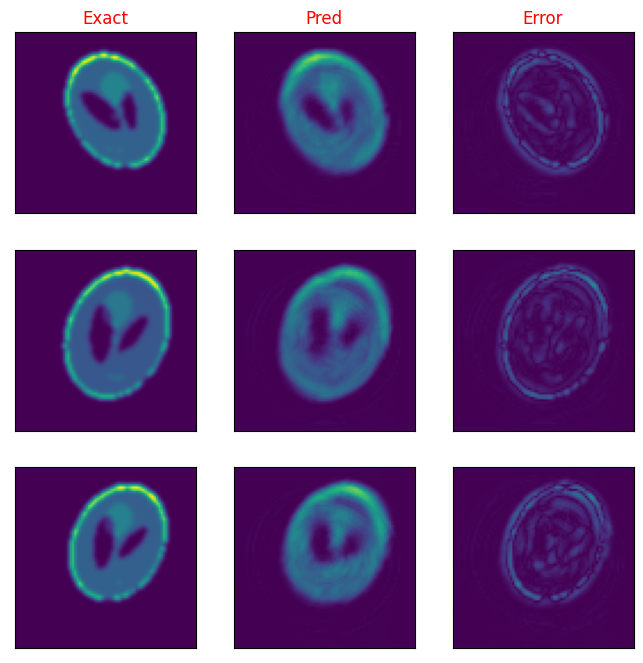

relative error = 32.534 %
Current epoch: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Time taken for 19 = 6.12s
Start of epoch 20-39


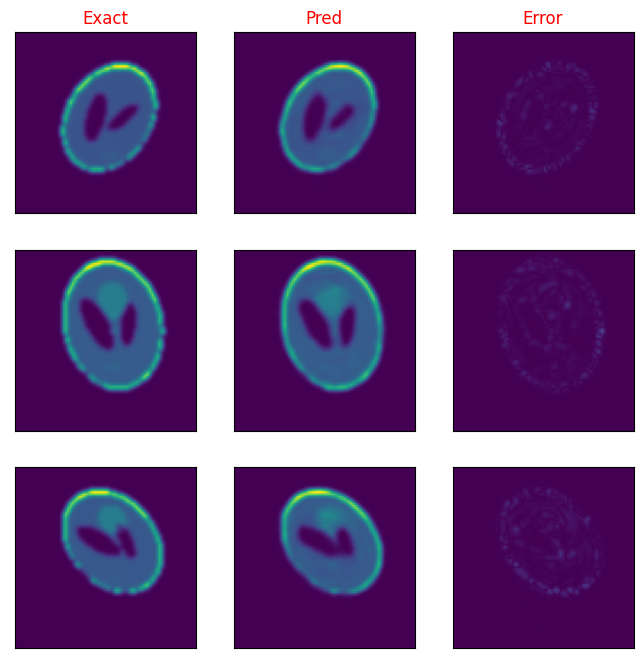

relative error = 7.741 %
Current epoch: 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 
Time taken for 39 = 6.09s
Start of epoch 40-59


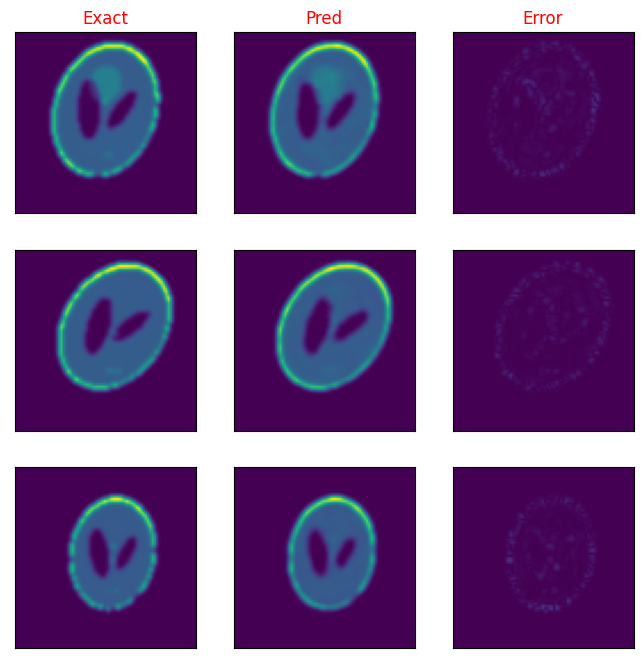

relative error = 6.778 %
Current epoch: 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 
Time taken for 59 = 6.09s
Start of epoch 60-79


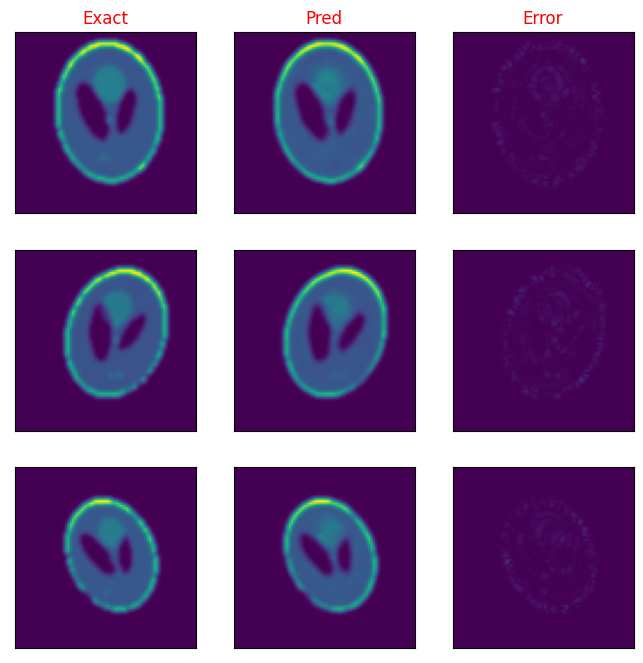

relative error = 6.246 %
Current epoch: 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 
Time taken for 79 = 6.23s


In [98]:
NUM_EPOCHS = 80
try:
    for epoch in range(NUM_EPOCHS):      
        """ plot training results """
        start_time = time.perf_counter()
        for step, trn_batch in enumerate(trn_dataset):
            _ = train_step(trn_batch)
        duration = time.perf_counter()-start_time
        
        if epoch % 20 == 0:
            print(f'===================\nStart of epoch {epoch}-{epoch+19}')
            X, yexact = trn_batch[0], trn_batch[1]
            ypred = model(X) 
            
            err = tf.abs(ypred-yexact)
            errors = np.zeros(BATCH_SIZE)
            for i in range(BATCH_SIZE):
                errors[i] = np.sqrt(tf.reduce_sum(err[i,:,:]**2, axis=[-2, -1])
                               / tf.reduce_sum(yexact[i,:,:]**2, axis=[-2, -1]))
                
            plt.figure(figsize=(8,8))
            NPLOT = 3
            for kk in range(NPLOT):
                plt.subplot(NPLOT, 3, kk*NPLOT + 1)
                plt.imshow(yexact[kk,:,:])
                plt.xticks([]); plt.yticks([]); clim = plt.gci().get_clim();
                if kk == 0:
                    plt.title('Exact', color='red')
            
                plt.subplot(NPLOT, 3, kk*NPLOT + 2)
                plt.imshow(ypred[kk,:,:])
                plt.xticks([]); plt.yticks([]); plt.gci().set_clim(clim);
                if kk == 0:
                    plt.title('Pred', color='red')
            
                plt.subplot(NPLOT, 3, kk*NPLOT + 3)
                plt.imshow(err[kk,:,:])
                plt.xticks([]); plt.yticks([]); plt.gci().set_clim(clim);
                if kk == 0:
                    plt.title('Error', color='red')                
            plt.show()
            
            print('relative error = %.3f' % np.mean(100*errors), '%')
            print('Current epoch:', end =" ")
            
        print(epoch, end =" ")
        
        
            
        if epoch % 20 == 19:
            print(f'\nTime taken for {epoch} = %.2fs' % duration)
            
        trn_loss_metric.reset_states()
        
except KeyboardInterrupt:
    pass

In [101]:
# Process testing data
with h5py.File(name+'/eta.h5', 'r') as f: 
    eta_test = f[list(f.keys())[0]][NTRAIN:NTRAIN+NTEST,:].reshape(-1, neta, neta)
    blur_fn = lambda x : gaussian_filter(x, sigma=blur_sigma)
    eta_test = np.stack([blur_fn(eta_test[i,:,:]) for i in range(NTEST)]).astype('float32')
    
with h5py.File(name+'/scatter.h5', 'r') as f:
    keys = natsort.natsorted(f.keys())
    # Process real part
    tmp1 = f[keys[3]][NTRAIN:NTRAIN+NTEST,:].reshape((-1,nx,nx))
    tmp2 = f[keys[4]][NTRAIN:NTRAIN+NTEST,:].reshape((-1,nx,nx))
    tmp3 = f[keys[5]][NTRAIN:NTRAIN+NTEST,:].reshape((-1,nx,nx))
    scatter_re = np.stack((tmp1, tmp2, tmp3), axis=-1)
    # Process imaginary part
    tmp1 = f[keys[0]][NTRAIN:NTRAIN+NTEST,:].reshape((-1,nx,nx))
    tmp2 = f[keys[1]][NTRAIN:NTRAIN+NTEST,:].reshape((-1,nx,nx))
    tmp3 = f[keys[2]][NTRAIN:NTRAIN+NTEST,:].reshape((-1,nx,nx))
    scatter_im = np.stack((tmp1, tmp2, tmp3), axis=-1)
    
    scatter_test = np.stack((scatter_re, scatter_im), axis=1).astype('float32')
    del scatter_re, scatter_im, tmp1, tmp2, tmp3
    

In [102]:
# Computing validation error 
val_errors = np.zeros(NTEST)
eta_pred = model(scatter_test)
val_err = tf.abs(eta_pred-eta_test)

for i in range(NTEST):
    val_errors[i] = np.sqrt(tf.reduce_sum(val_err[i,:,:]**2, axis=[-2, -1])
                          / tf.reduce_sum(eta_test[i,:,:]**2, axis=[-2, -1]))

print('validation error = %.3f' % np.mean(100*val_errors), '%') 
  

validation error = 6.346 %
